In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pingouin as pg

/opt/miniconda3/envs/databs/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.6, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/opt/miniconda3/envs/databs/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
spines = pd.read_csv('/Users/labc02/Documents/PDCB_data/Morphometry/Spine_Count.csv')

In [45]:
sp_TE = spines[spines['Order'] < 3]
sp_normal = spines[spines['Order'] == 3]

In [9]:
spines.columns

Index(['ID', 'Genotype', 'Sample', 'Order', 'Lenght', 'Spines'], dtype='object')

### Thorny Excrescences 

In [7]:
sp_TE.groupby(['Genotype'])['ID'].count()

Genotype
KO    12
WT    15
Name: ID, dtype: int64

#### Thorny excrescence expressed as number of spine heads in 20 micrometers of dendrite

In [10]:
sp_TE['Density'] = sp_TE['Spines']/sp_TE['Lenght'] * 20

<ipython-input-10-088b22520e60>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_TE['Density'] = sp_TE['Spines']/sp_TE['Lenght'] * 20


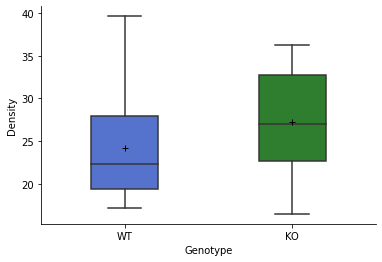

In [13]:
sns.boxplot(data = sp_TE, x = 'Genotype', y = 'Density', palette=['royalblue', 'forestgreen'], order = ['WT', 'KO'], showmeans=True, showfliers = True, meanprops={'marker':'+', 'markeredgecolor':'k'}, width=0.4)
sns.despine()

In [14]:
pg.normality(data = sp_TE, dv = 'Density', group = 'Genotype')

,W,pval,normal
KO,0.936478,0.453832,True
WT,0.875469,0.040628,False


In [20]:
pg.mwu(x = sp_TE['Density'][sp_TE['Genotype']=='WT'], y = sp_TE['Density'][sp_TE['Genotype']=='KO'], tail ='one-sided')

,U-val,tail,p-val,RBC,CLES
MWU,68.0,less,0.147068,0.244444,0.622222


#### A tendency in accordance to the propotion of axons with MFB and Timm area, but no statistically significant

### Normal spines

In [46]:
sp_normal.groupby(['Genotype'])['ID'].count()

Genotype
KO    21
WT    20
Name: ID, dtype: int64

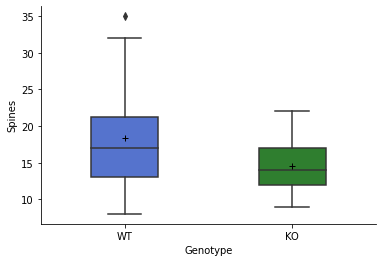

In [47]:
sns.boxplot(data = sp_normal, x = 'Genotype', y = 'Spines', palette=['royalblue', 'forestgreen'], order = ['WT', 'KO'], showmeans=True, showfliers = True, meanprops={'marker':'+', 'markeredgecolor':'k'}, width=0.4)
sns.despine()

#### Outlier detection

In [49]:
out_WT = pg.madmedianrule(sp_normal['Spines'][sp_normal['Genotype'] == 'WT'])

In [50]:
sp_normal['Spines'][sp_normal['Genotype'] == 'WT'][out_WT]

39    35
41    32
Name: Spines, dtype: int64

In [51]:
sp_tidy = sp_normal.drop(index = [39, 41])

In [53]:
sp_tidy.groupby('Genotype')['ID'].count()

Genotype
KO    21
WT    18
Name: ID, dtype: int64

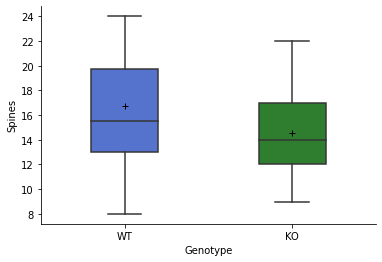

In [57]:
sns.boxplot(data = sp_tidy, x = 'Genotype', y = 'Spines', palette=['royalblue', 'forestgreen'], order = ['WT', 'KO'], showmeans=True, showfliers = False, meanprops={'marker':'+', 'markeredgecolor':'k'}, width=0.4)
sns.despine()

In [59]:
pg.normality(data = sp_tidy, dv = 'Spines', group = 'Genotype')

,W,pval,normal
KO,0.967427,0.675686,True
WT,0.960308,0.607598,True


In [62]:
pg.ttest(sp_tidy['Spines'][sp_tidy['Genotype']=='WT'], sp_tidy['Spines'][sp_tidy['Genotype']=='KO'])

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.482769,28.679949,two-sided,0.149042,"[-0.84, 5.23]",0.491298,0.738,0.319438


#### A tendency in the other direction, not significant